In [5]:
import numpy as np, scipy as scp, matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

plt.style.use(['science','notebook','grid', 'dark_background'])

The Net Force acting on a body moving with air friction under gravity is given by $$\vec F_{net}=-mg \hat y - b \sqrt{{\dot x}^2 + {\dot y}^2}(\dot x \hat x + \dot y \hat y)$$ 
Using the fact that $$\vec F_{net}=m \langle \ddot x, \ddot y \rangle$$ we get two coupled DEs $$\ddot x=-\frac{b}{m}\sqrt{{\dot x}^2 + {\dot y}^2}\dot x$$ $$\ddot y=-g-\frac{b}{m}\sqrt{{\dot x}^2 + {\dot y}^2}\dot y$$ By defining $x'=x/g$ and $y'=y/g$ we get the following python-compatible equations: $$\ddot x'=-\frac{bg}{m}\sqrt{{\dot x}^2 + {\dot y}^2}\dot x'$$ $$\ddot y'=-1-\frac{bg}{m}\sqrt{{\dot x}^2 + {\dot y}^2}\dot y'$$

We get a 4-DE system: 
1. $\dot x=v_x$
2. $\dot v_x=-B\sqrt{{\dot x}^2 + {\dot y}^2}\dot x$
3. $\dot y=v_y$
4. $\dot v_y=-1-B\sqrt{{\dot x}^2 + {\dot y}^2}\dot y$

as $B=bg/m$. Define $\vec S=(x,y_x,y,v_y):$

In [6]:
def dSdt(t, S, B):
    x, vx, y, vy = S
    return [
        vx,
        -B * np.sqrt(vx ** 2 + vy ** 2) * vx,
        vy,
        -1 - B * np.sqrt(vx ** 2 + vy ** 2) * vy
    ]

B = 1
V = 1

t1 = 40 * np.pi / 180
t2 = 45 * np.pi / 180
t3 = 50 * np.pi / 180

In [7]:
sol1 = solve_ivp(dSdt, [0, 2], y0 = [0, V * np.cos(t1), 0, V * np.sin(t1)], t_eval = np.linspace(0, 2, 1000), args = (B, ))
sol2 = solve_ivp(dSdt, [0, 2], y0 = [0, V * np.cos(t2), 0, V * np.sin(t2)], t_eval = np.linspace(0, 2, 1000), args = (B, ))
sol3 = solve_ivp(dSdt, [0, 2], y0 = [0, V * np.cos(t3), 0, V * np.sin(t3)], t_eval = np.linspace(0, 2, 1000), args = (B, ))

(0.0, 0.2543321811839284)

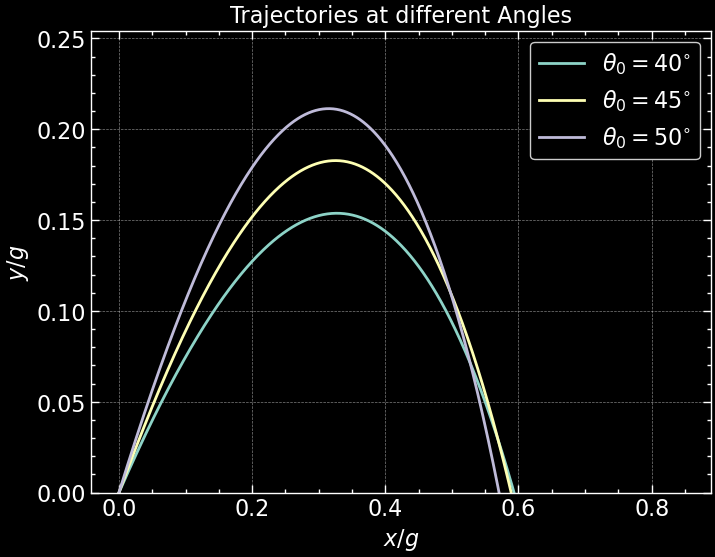

In [17]:
plt.plot(sol1.y[0], sol1.y[2], label = r'$\theta_0=40^{\circ}$')
plt.plot(sol2.y[0], sol2.y[2], label = r'$\theta_0=45^{\circ}$')
plt.plot(sol3.y[0], sol3.y[2], label = r'$\theta_0=50^{\circ}$')

plt.title('Trajectories at different Angles')
plt.legend()
plt.xlabel(r'$x/g$')
plt.ylabel(r'$y/g$')
plt.ylim(bottom = 0)

In [13]:
def distance(angle, B, V = 1, t = 2):
    v0_x = V * np.cos(angle * np.pi / 180)
    v0_y = V * np.sin(angle * np.pi / 180)

    sol = solve_ivp(dSdt, [0, t], y0 = [0, v0_x, 0, v0_y], t_eval = np.linspace(0, t, 10000), args = (B, ), atol = 1e-07, rtol = 1e-04)
    
    just_above_idx = np.where(np.diff(np.sign(sol.y[2])) < 0)[0][0]
    just_below_idx = just_above_idx + 1
    
    x_loc = (sol.y[0][just_above_idx] + sol.y[0][just_below_idx]) / 2
    return x_loc

Text(0, 0.5, 'Range per unit gravity [Distance / g]')

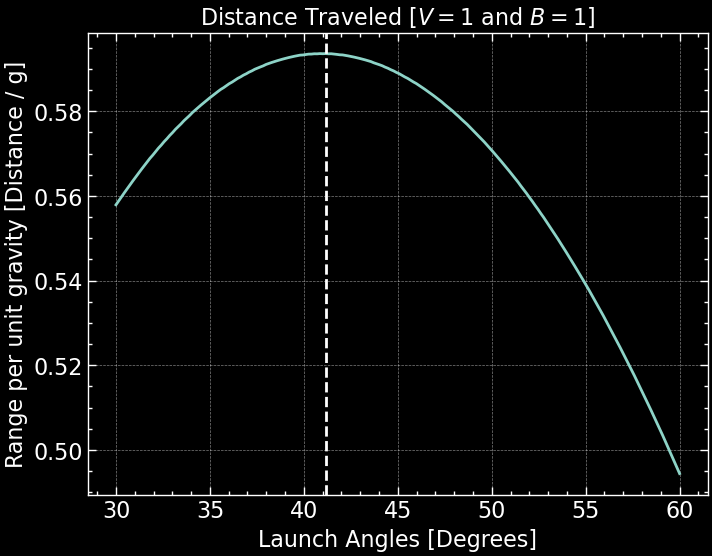

In [14]:
angles = np.linspace(30, 60, 200)
x_locs = np.vectorize(distance)(angles, B = 1)

plt.plot(angles, x_locs)
plt.axvline(angles[np.argmax(x_locs)], ls = '--', color = 'w')

plt.title(r'Distance Traveled [$V=1$ and $B=1$]')
plt.xlabel('Launch Angles [Degrees]')
plt.ylabel('Range per unit gravity [Distance / g]')

Finding the angles yielding maximum distances as a function of B:

In [18]:
V1 = 1
V2 = 2

angles = np.linspace(35, 45, 200)
Bs =  np.linspace(0, 1, 50)

results_v1 = [np.vectorize(distance)(angles, B = B, V = V1) for B in Bs]
opt_angles_v1 = [angles[np.argmax(result)] for result in results_v1]
results_v2 = [np.vectorize(distance)(angles, B = B, V = V2, t = 6) for B in Bs]
opt_angles_v2 = [angles[np.argmax(result)] for result in results_v2]

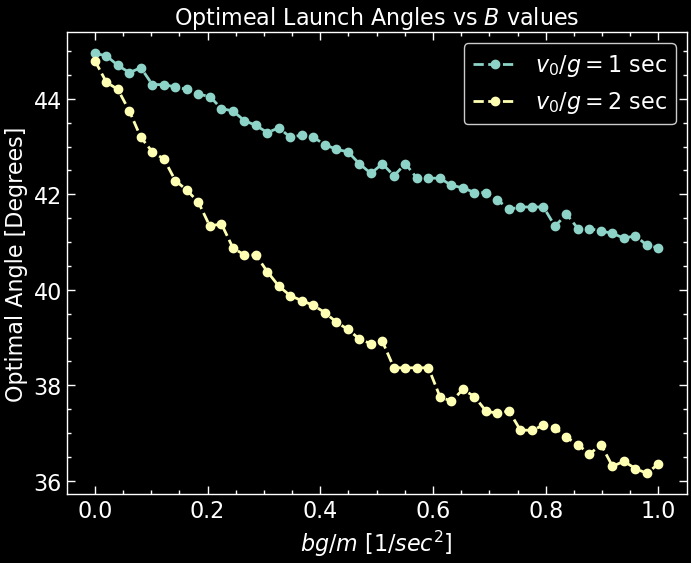

In [20]:
plt.plot(Bs, opt_angles_v1, 'o--', label = '$v_0/g=1$ sec')
plt.plot(Bs, opt_angles_v2, 'o--', label = '$v_0/g=2$ sec')

plt.title('Optimeal Launch Angles vs $B$ values')
plt.legend()
plt.xlabel(r'$bg/m$ [$1/{sec}^2$]')
plt.ylabel(r'Optimal Angle [Degrees]')
plt.grid()

How does this correspond to regular objects? Lets look at a golf ball and a football:

Now $b=\displaystyle \frac{1}{2}\rho AC_d$
- For a golf ball, $m=0.045$ kg, $r=0.021$ m and $C_d \approx 0.5$
- For a football, $m=0.45$ kg, $r=0.11$ m and $C_d \approx 0.2$
- $\rho_{air}=1.225$ kg/cubic metre

The formula for $B$ becomes $$B=\frac{bg}m=\frac 1 2 \frac{\rho_{air}\pi r^2C_dg}{m}$$

In [21]:
rho = 1.225
g = 9.807

r = 0.021
Cd = 0.5
m = 0.045
B_golf = 0.5 * rho * np.pi * r ** 2 * Cd * g / m

r = 0.22 / 2
Cd = 0.2
m = 0.45
B_foot = 0.5 * rho * np.pi * r ** 2 * Cd * g / m

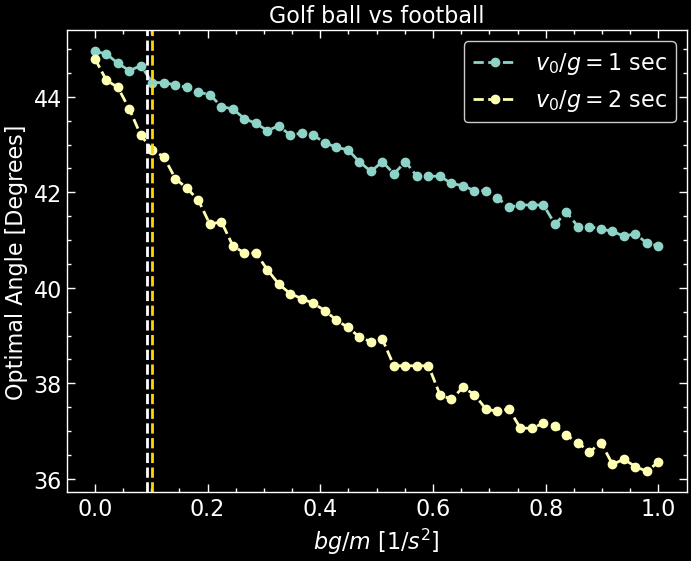

In [22]:
plt.plot(Bs, opt_angles_v1, 'o--', label = '$v_0/g=1$ sec')
plt.plot(Bs, opt_angles_v2, 'o--', label = '$v_0/g=2$ sec')

plt.axvline(B_golf, ls = '--', color = 'white')
plt.axvline(B_foot, ls = '--', color = 'gold')

plt.title('Golf ball vs football')
plt.legend()
plt.xlabel('$bg/m$ [$1/s^2$]')
plt.ylabel('Optimal Angle [Degrees]')
plt.grid()